In [1]:
from time import time

import pyart
import numpy as np
import os, sys
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

import leroi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#configure gridding
gs = (40, 301, 301)
gb = ((500, 20000), (-150000,150000),(-150000,150000))
center_pos = (0,0,0)
x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])

def _load_radar(odimh5_ffn, dbz_fname, grid_fields):
    #read radar data
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        radar = pyart.aux_io.read_odim_h5(odimh5_ffn, file_field_names=True)
    #add height field
    radar.add_field_like(dbz_fname, 'height', radar.gate_altitude['data'])
    #mask invalid
    radar = leroi.mask_invalid_data(radar, dbz_fname, add_to = grid_fields, min_field = 0, min_area = 50, return_smooth = False)
    return radar

def run_leroi_grid(odimh5_ffn, dbz_fname='DBZH', grid_fields=['DBZH','VRADH'], Rc=3500, k=200):
    #For a 1km grid out to 150km range, Rc of 3500m and k of 300 is sufficent.
    #load data
    radar = _load_radar(odimh5_ffn, dbz_fname, grid_fields)
    #run gridding
    fields = leroi.cressman_ppi_interp(radar, coords, grid_fields, Rc=Rc, k=k, verbose=False)
    grid = leroi.build_pyart_grid(radar, fields, gs, gb)
    
    return grid
    
        
def run_const_cressman(odimh5_ffn, dbz_fname, grid_fields, roi=3500):
    #load data
    radar = _load_radar(odimh5_ffn, dbz_fname, grid_fields)
    #init latlon
    lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]
    #run gridding
    gatefilter = pyart.correct.GateFilter(radar)
    gatefilter.exclude_masked(dbz_fname, exclude_masked=True)
    grid = pyart.map.grid_from_radars(radar, grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'constant', constant_roi = roi,
                                      weighting_function = 'Cressman', grid_limits=gb, fields=grid_fields, gatefilter=gatefilter)
    return grid

def run_test(odim_ffn, dbz_fname, vrad_name, grid_fields, level=5, yidx=145, k=200):
    
    #grid
    start = time()
    leroi_grid = run_leroi_grid(odim_ffn, dbz_fname=dbz_fname, grid_fields=grid_fields, k=k)
    end = time()
    leroi_time = end-start
    
    start = time()
    pyart_grid = run_const_cressman(odim_ffn, dbz_fname=dbz_fname, grid_fields=grid_fields)
    end = time()
    pyart_time = end-start
    
    #plot horizontal cross section
    fig = plt.figure(figsize=[14,14])
    leroi_display = pyart.graph.GridMapDisplay(leroi_grid)
    pyart_display = pyart.graph.GridMapDisplay(pyart_grid)
    
    ax = plt.subplot(221)
    ax.set_title(f'leroi reflectivity grid. Runtime:{leroi_time:.2f}s')
    img = plt.pcolormesh(y,x,leroi_grid.fields[dbz_fname]['data'][level,:,:], vmin=0, vmax=60, cmap='pyart_HomeyerRainbow')
    plt.plot([-150000,150000],[-150000+yidx*1000,-150000+yidx*1000],'k-')
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('dBZ')
    plt.grid()
    
    ax = plt.subplot(222)
    ax.set_title(f'pyart reflectivity grid. Runtime:{pyart_time:.2f}s')
    img = plt.pcolormesh(y,x,pyart_grid.fields[dbz_fname]['data'][level,:,:], vmin=0, vmax=60, cmap='pyart_HomeyerRainbow')
    plt.plot([-150000,150000],[-150000+yidx*1000,-150000+yidx*1000],'k-')
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('dBZ')
    plt.grid()
    
    if vrad_name is not None:
        ax = plt.subplot(223)
        ax.set_title(f'leroi velocity grid. Runtime:{leroi_time:.2f}s')
        img = plt.pcolormesh(y,x,leroi_grid.fields[vrad_name]['data'][level,:,:], vmin=-15, vmax=15, cmap=pyart.graph.cm._generate_cmap('BuOr12',100))
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('m/s')
        plt.grid()

        ax = plt.subplot(224)
        ax.set_title(f'pyart velocity grid. Runtime:{pyart_time:.2f}s')
        img = plt.pcolormesh(y,x,pyart_grid.fields[vrad_name]['data'][level,:,:], vmin=-15, vmax=15, cmap=pyart.graph.cm._generate_cmap('BuOr12',100))
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('m/s')
        plt.grid()
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(211)
    m = ax.pcolormesh(x,z,leroi_grid.fields[dbz_fname]['data'][:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
    plt.colorbar(m)
    plt.grid()
    ax.set_title('Leroi reflectivity grid')
    
    ax = fig.add_subplot(212)
    m = ax.pcolormesh(x,z,pyart_grid.fields[dbz_fname]['data'][:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
    plt.colorbar(m)
    plt.grid()
    ax.set_title('Pyart reflectivity grid')

    plt.show()
    
    return None
    
    

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:401: UserWarning: 
 There are invalid height values which will 
        ruin the linear interpolation. This most likely means the radar
        doesnt cover the entire gridded domain
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:213: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: U

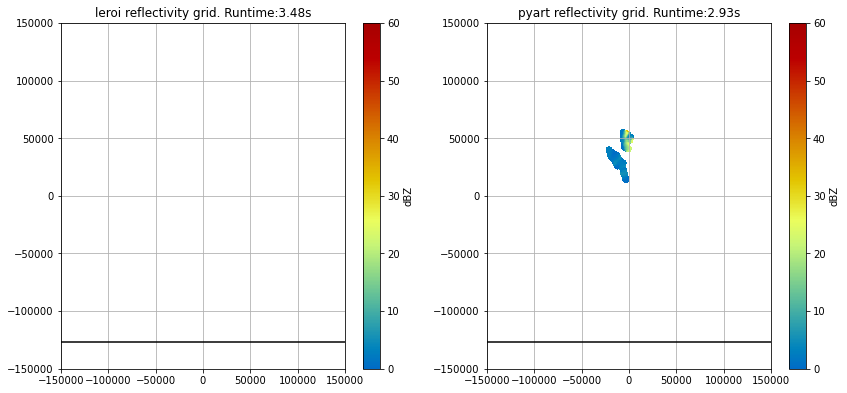

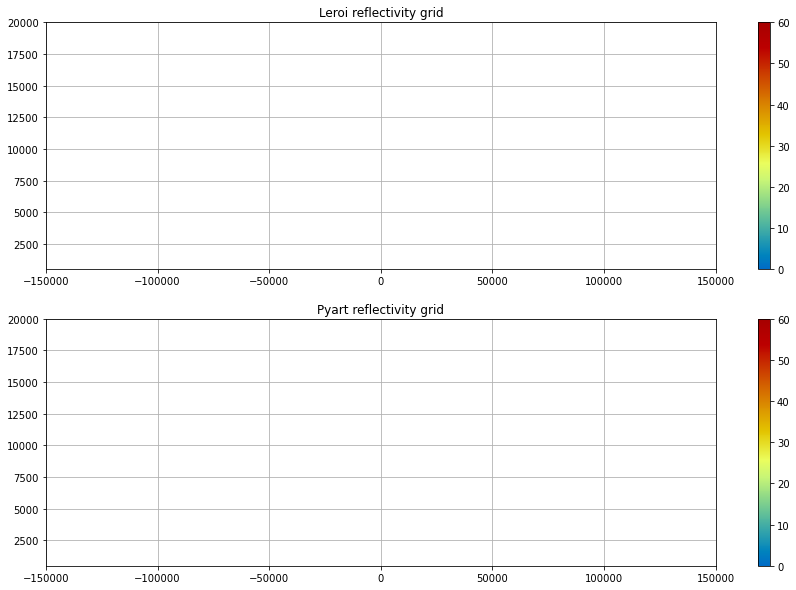

In [3]:
#local file test
odim_ffn = '50_20200915_004154.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name=None, grid_fields=['DBZH'], yidx=23, level=1)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:271: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:161: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

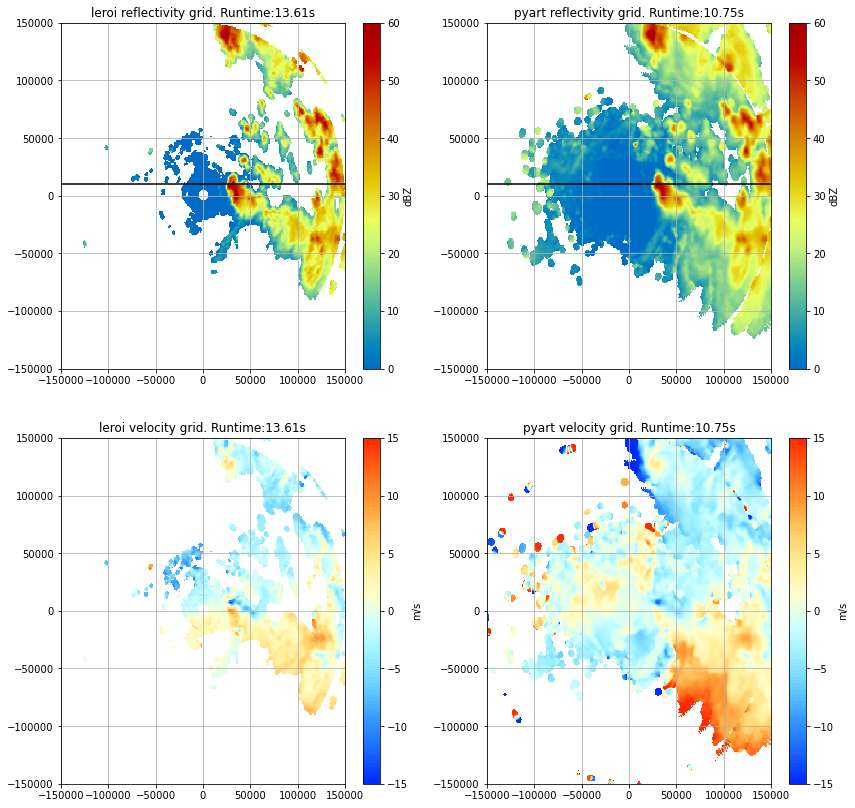

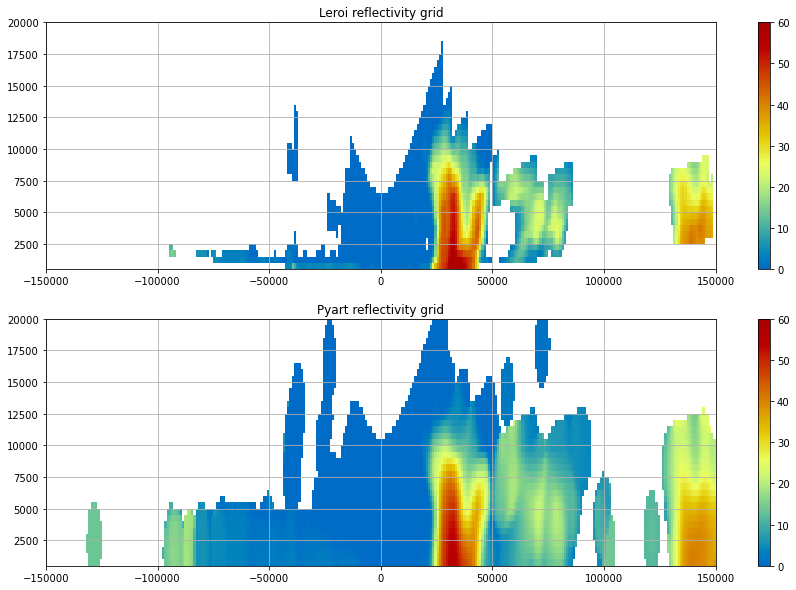

In [13]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/dp/02_20200119_050031.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'],yidx=160)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:256: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

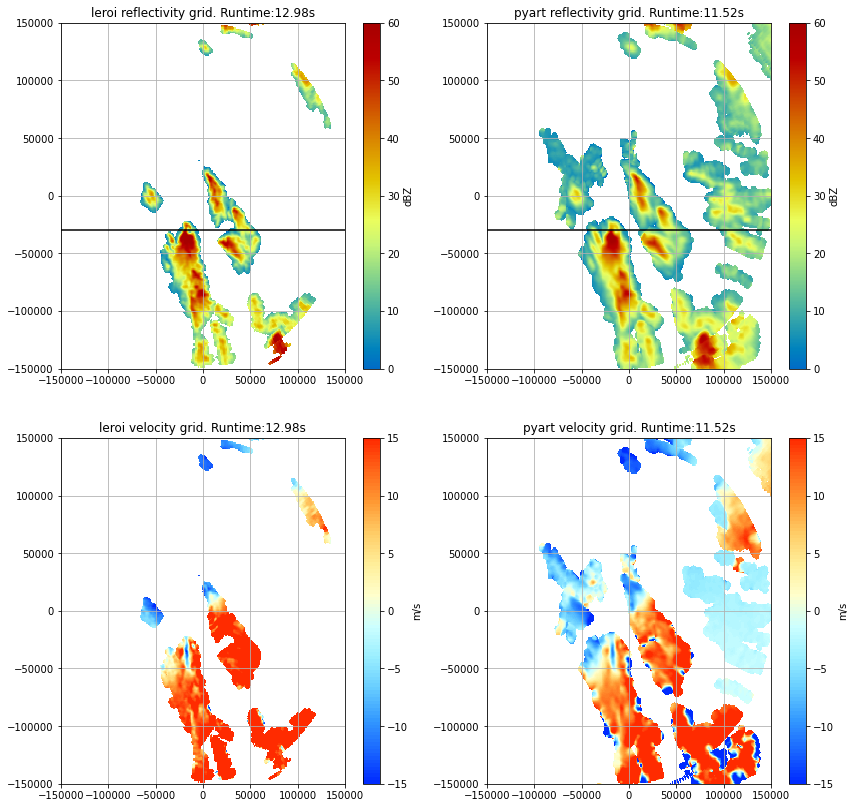

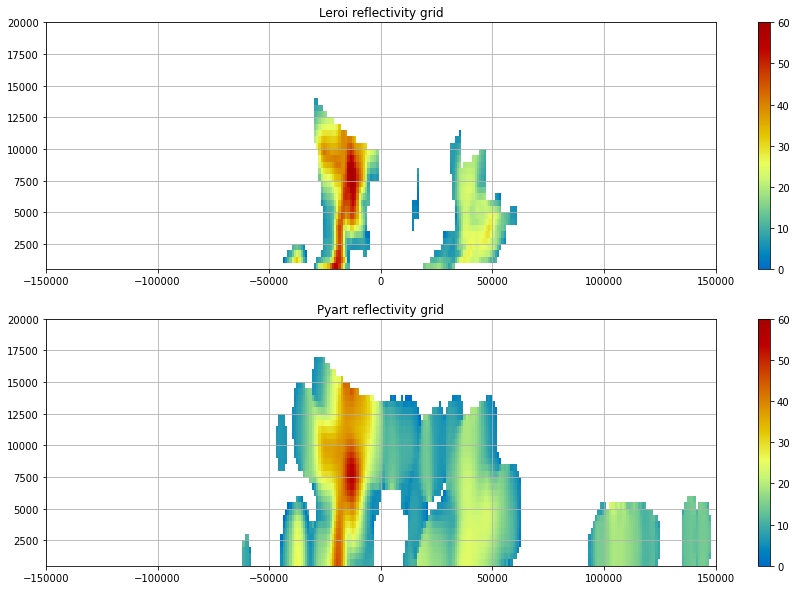

In [22]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/dp/71_20200120_060026.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'], yidx=120)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:256: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

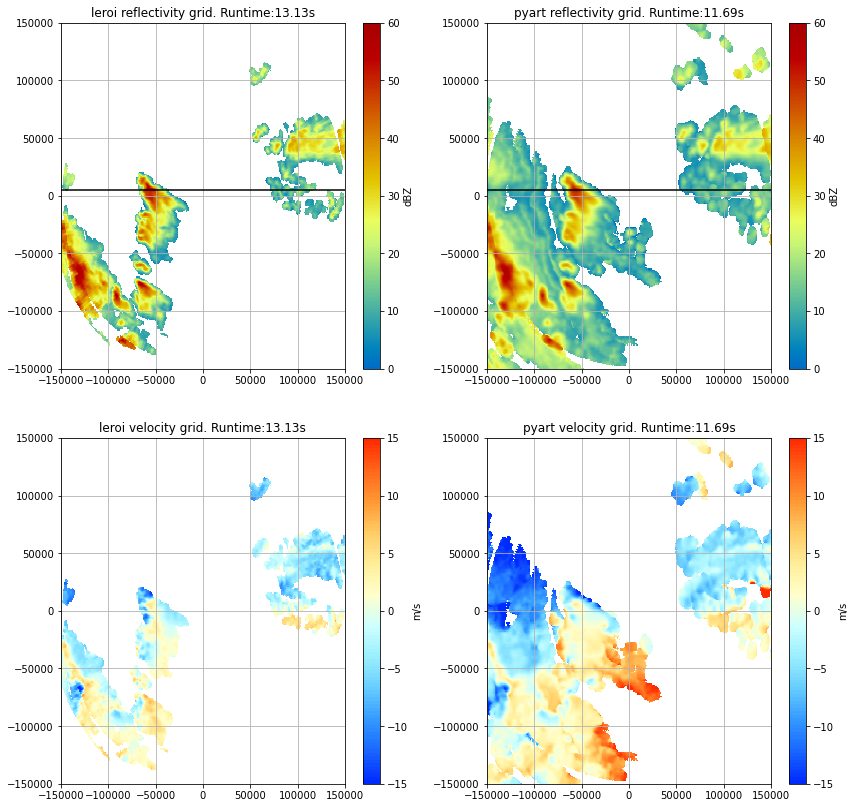

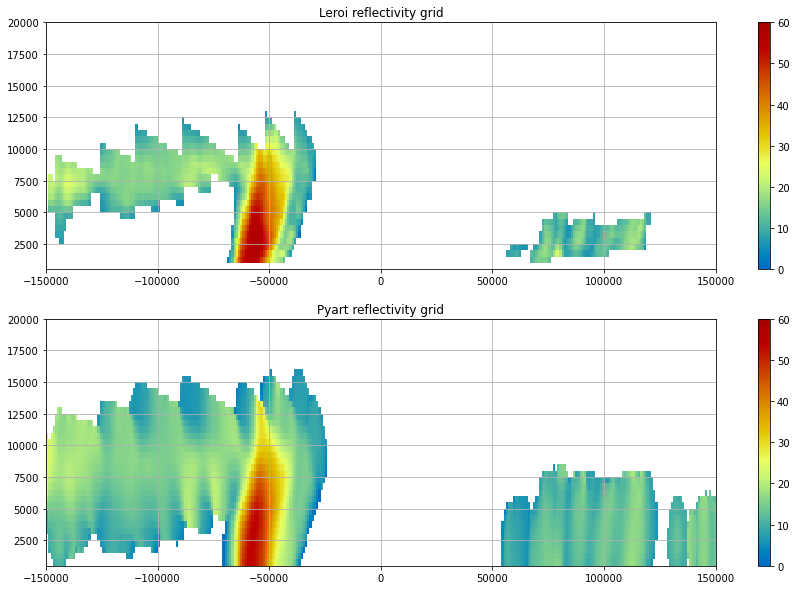

In [23]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/dp/66_20181214_063031.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'], yidx=155)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:256: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

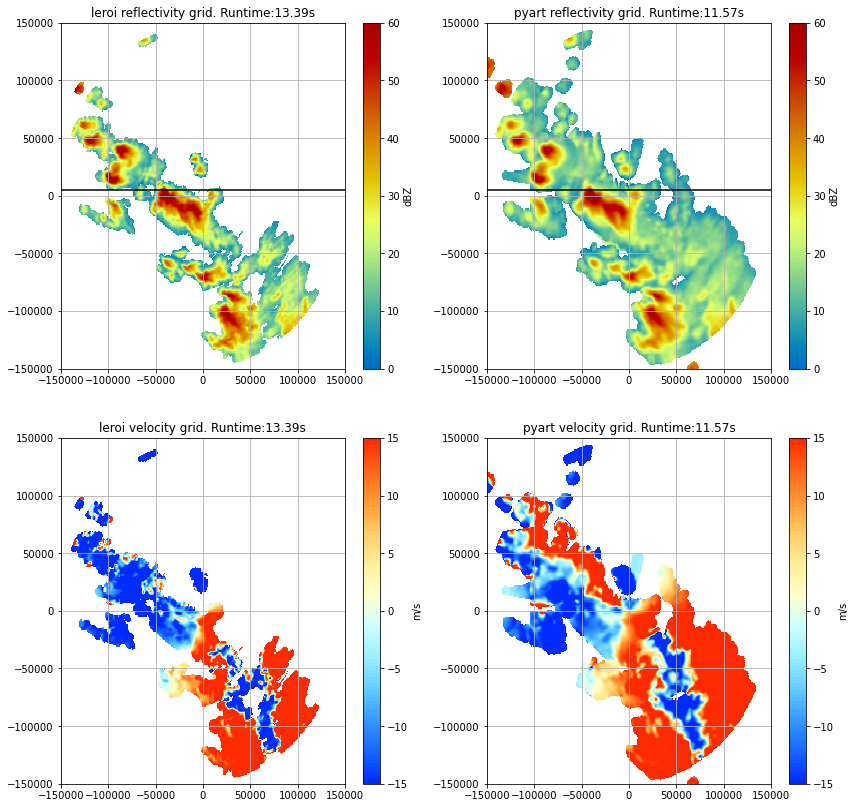

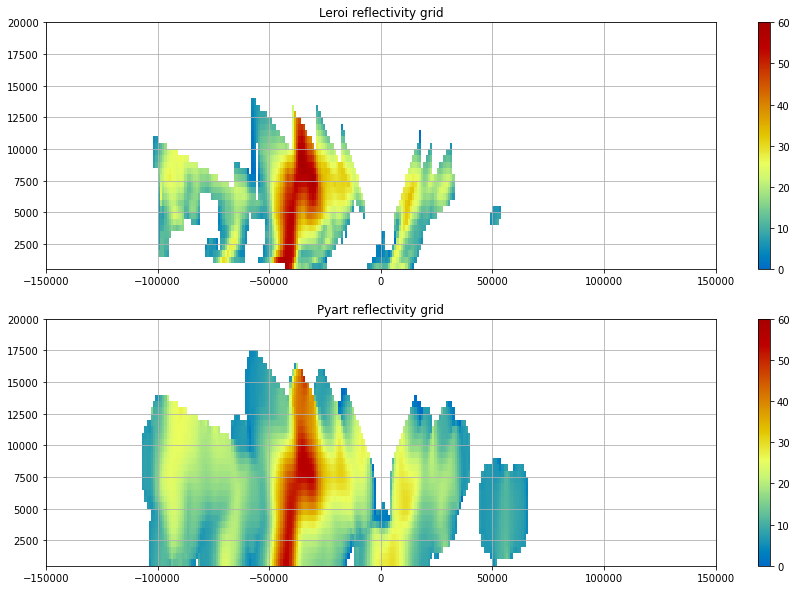

In [24]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/dp/66_20201031_040026.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'], yidx=155)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:256: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

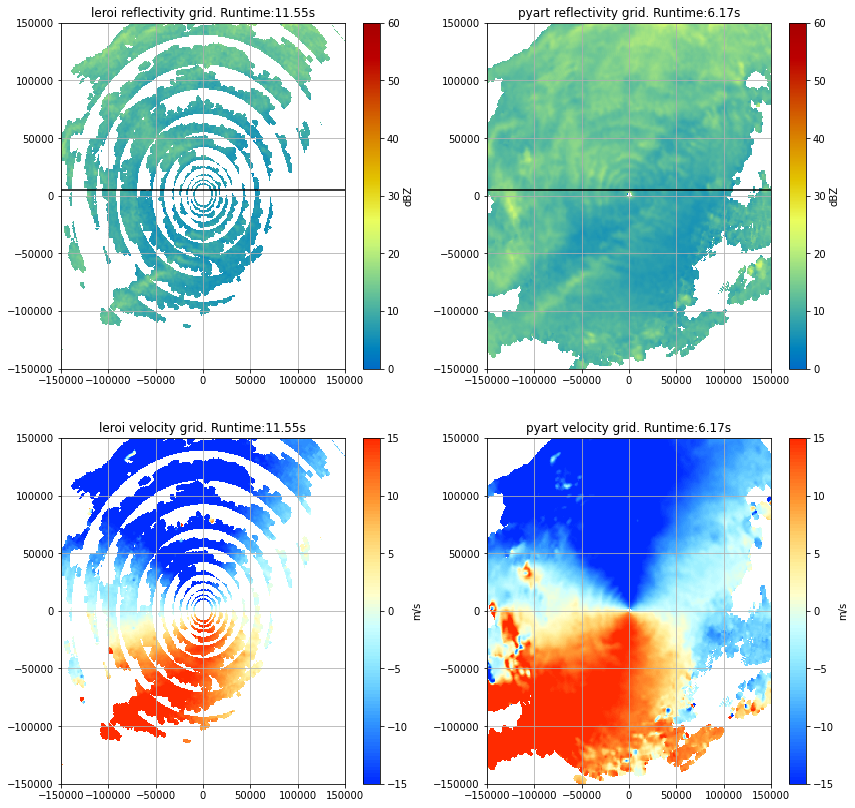

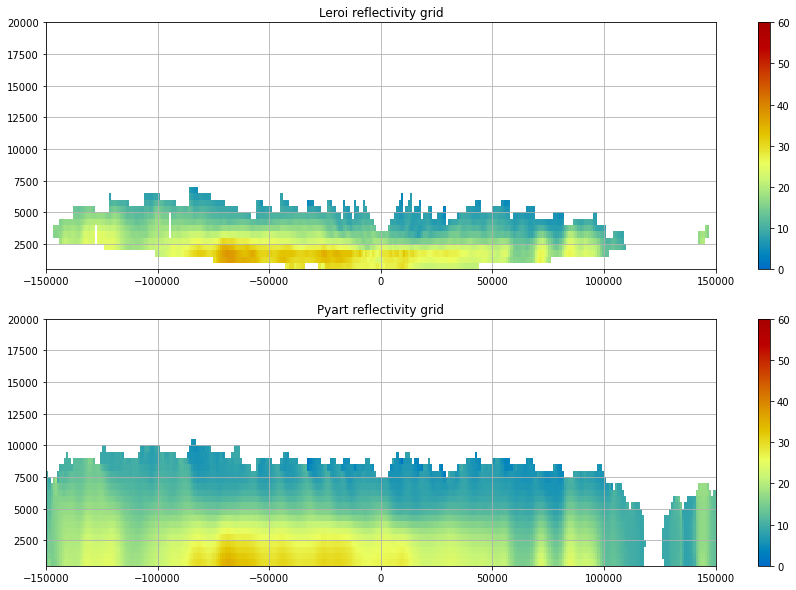

In [25]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/dualprf/3_20200807_055400_ECL_dualprf.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'], yidx=155, level=10)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/g/data/en0/

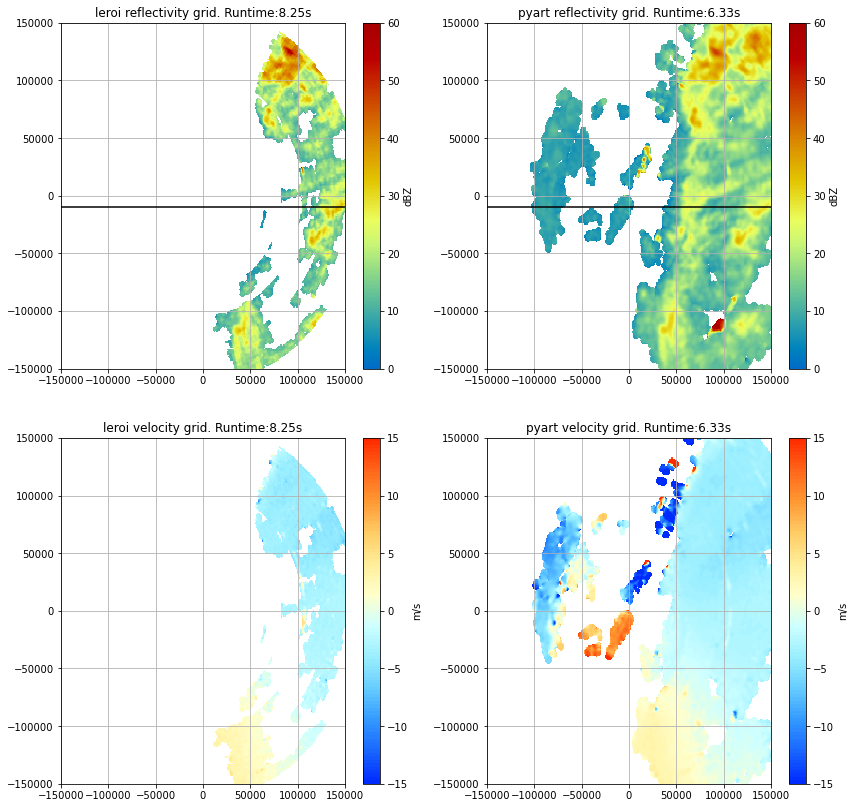

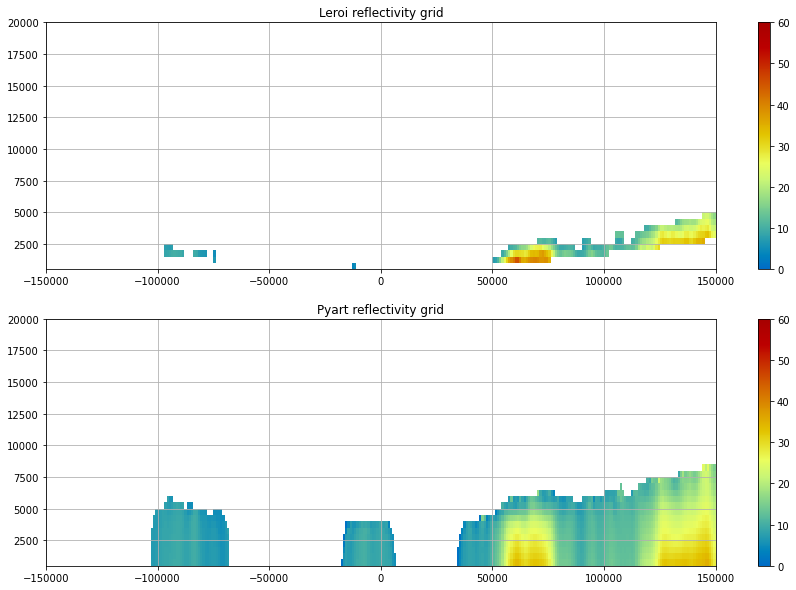

In [26]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/sea_clutter/03_20200122_100030_noprecip.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'], yidx=140)

In [ ]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/ground_clutter/64_20201111_012000.pvol.h5'
run_test(odim_ffn, dbz_fname='DBZH', vrad_name='VRADH', grid_fields=['DBZH','VRADH'], yidx=140, k=100)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:256: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:315: UserWarning: 
 There are invalid height values which will 
        ruin the linear interpolation. This most likely means the radar
        doesnt cover the entire gridded domain
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: Us

In [44]:
odim_ffn = '/home/548/jss548/dev/tmp/testing_files/dp/66_20201031_040026.pvol.h5'
grid_less =  run_leroi_grid(odim_ffn, dbz_fname='DBZH', grid_fields=['DBZH','VRADH'], Rc=3500, k=100)
grid_more =  run_leroi_grid(odim_ffn, dbz_fname='DBZH', grid_fields=['DBZH','VRADH'], Rc=3500, k=200)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:256: UserWarning: 
 Some points are being left out of radius of influence, make 'k' bigger!
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/leroi-0.0.1-py3.9.egg/leroi/leroi.py:150: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/numpy/ma/core.py:3220: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-7515202b3636>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(x,z,grid_less.fields['DBZH']['data'][:,150,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
<ipython-input-47-7515202b3636>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

Text(0.5, 1.0, 'Different (more-less) reflectivity grid')

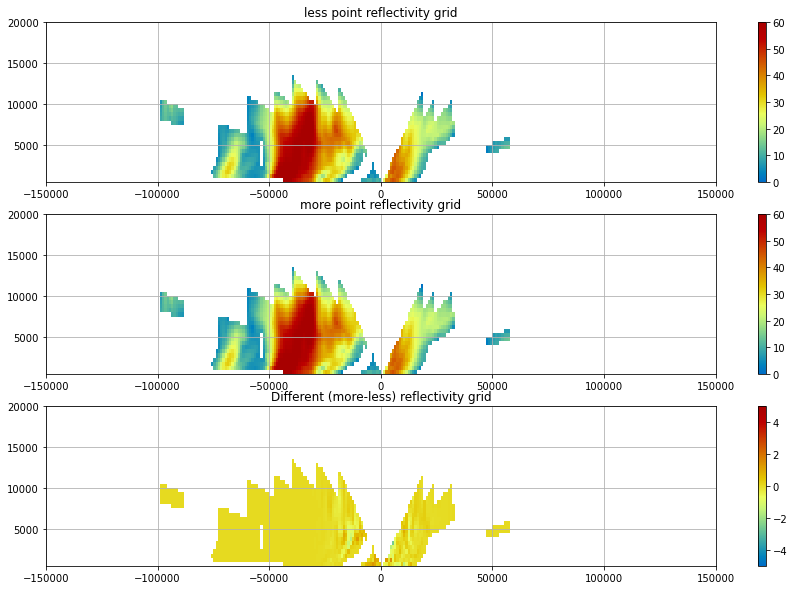

In [47]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(311)
m = ax.pcolormesh(x,z,grid_less.fields['DBZH']['data'][:,150,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
plt.colorbar(m)
plt.grid()
ax.set_title('less point reflectivity grid')

ax = fig.add_subplot(312)
m = ax.pcolormesh(x,z,grid_more.fields['DBZH']['data'][:,150,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 60)
plt.colorbar(m)
plt.grid()
ax.set_title('more point reflectivity grid')


ax = fig.add_subplot(313)
m = ax.pcolormesh(x,z,grid_more.fields['DBZH']['data'][:,150,:]-grid_less.fields['DBZH']['data'][:,150,:], cmap ='pyart_HomeyerRainbow', vmin = -5, vmax = 5)
plt.colorbar(m)
plt.grid()
ax.set_title('Different (more-less) reflectivity grid')
